In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import roc_auc_score,auc,roc_curve

In [2]:
#Import dữ liệu đã được tiền xử lí
df = pd.read_csv('../../../BankChurners_Preprocessing.csv')

## Chọn Attrition_Flag làm thuộc tính quyết định. Nhưng vì Attrition_Flag đang bị mất cân bằng dữ liệu. Vậy nên ta cần xử lí mất cân bằng trước

Tách dữ liệu thành 2 phần. 1 phần chứa các cột còn lại và cột chứa thuộc tính quyết định.
features: Chứa các thuộc tính còn lại.
labels: Chứa thuộc tính quyết định.

In [3]:
features=df.drop('Attrition_Flag',axis=1)
labels=df['Attrition_Flag']

Chuyển đổi các cột không phải dạng số trong biến features về dạng one-hot vector

In [4]:
features_onehot=pd.get_dummies(features,columns=features.select_dtypes(exclude=['int64']).columns)

In [5]:
#Chia tập dữ liệu theo train 80%, test 20%
X_train, X_test, y_train, y_test = train_test_split(features_onehot, labels, test_size=0.2, random_state=42,shuffle=True)

In [6]:
# Áp dụng kỹ thuật Oversampling để làm cân bằng dữ liệu
oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

In [7]:
print(y_train_resampled.shape)
print(X_train_resampled.shape)

(13602,)
(13602, 21)


In [8]:
model = xgb.XGBClassifier(random_state=0)

In [9]:
params= {
    'n_estimators': [int(x) for x in np.arange(start = 100, stop = 501, step = 50)],
    'max_depth': [int(x) for x in np.arange(start = 10, stop = 101, step = 10)],
    'eta': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
    'subsample': [float(x) for x in np.arange(start = 0, stop = 1, step = 0.1)],
    'colsample_bytree': [float(x) for x in np.arange(start = 0, stop = 1, step = 0.1)],
    'gamma': [0, 1, 5],
    'min_child_weight': [float(x) for x in np.arange(start = 0, stop = 1, step = 0.1)],
    }

In [10]:
xgb_rd = RandomizedSearchCV(model,
                                   param_distributions = params,
                                   n_iter = 25,              
                                   refit = "recall",
                                   return_train_score = False,
                                   random_state = 0,
                                   cv = 3,
                                   n_jobs = -1) 

In [11]:
xgb_rd=xgb_rd.fit(X_train_resampled, y_train_resampled)

In [12]:
xgb_rd.best_params_

{'subsample': 0.6000000000000001,
 'n_estimators': 250,
 'min_child_weight': 0.1,
 'max_depth': 90,
 'gamma': 0,
 'eta': 0.1,
 'colsample_bytree': 0.4}

In [13]:
xgb_rd = xgb.XGBClassifier(
    subsample = 0.6000000000000001,
    n_estimators = 250,
    min_child_weight = 0.1,
    max_depth = 90,
    gamma = 0,
    eta = 0.1,
    colsample_bytree = 0.4
)

In [14]:
xgb_rd.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.4, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric=None,
              feature_types=None, gamma=0, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=90,
              max_leaves=None, min_child_weight=0.1, missing=nan,
              monotone_constraints=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [15]:
xgb_pred = xgb_rd.predict(X_test)
xgb_score=metrics.accuracy_score(y_test,xgb_pred)
print("Accuracy:",xgb_score)
print("Report:",metrics.classification_report(y_test,xgb_pred))

Accuracy: 0.9368213228035538
Report:               precision    recall  f1-score   support

           0       0.83      0.77      0.80       327
           1       0.96      0.97      0.96      1699

    accuracy                           0.94      2026
   macro avg       0.89      0.87      0.88      2026
weighted avg       0.94      0.94      0.94      2026



Text(0.5, 1.0, 'XGBoost Accuracy Score : 0.9368213228035538')

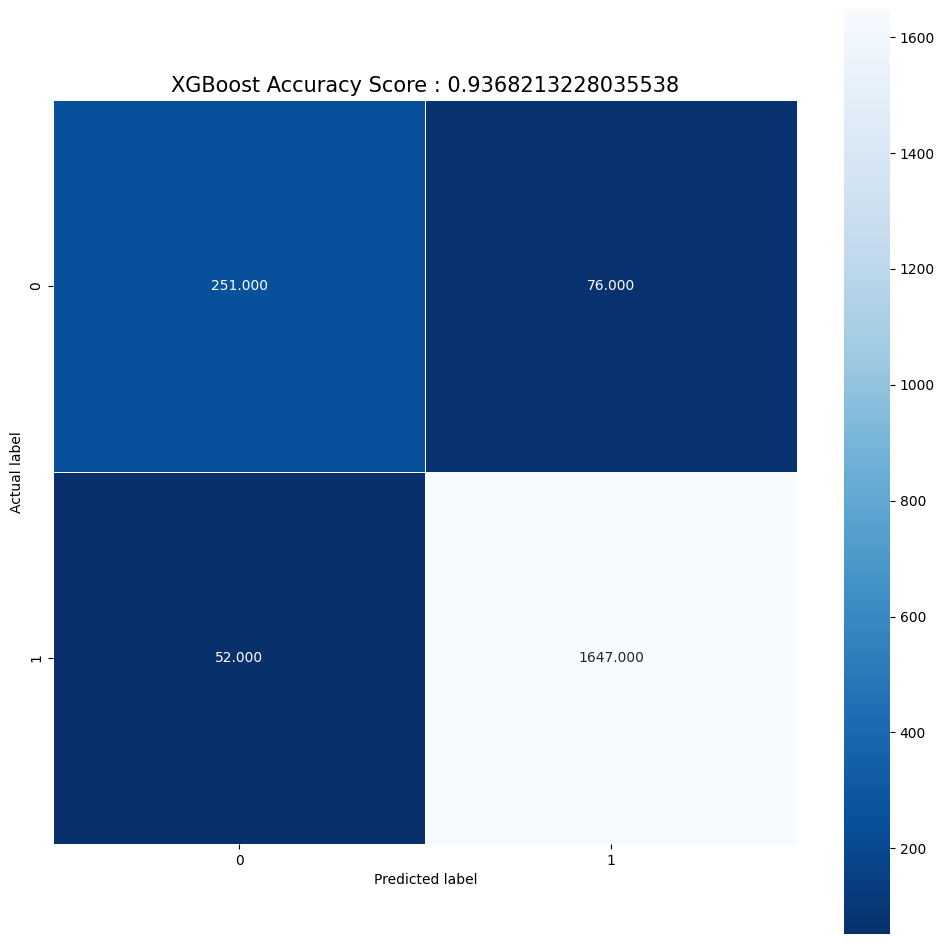

In [13]:
xgb_cm=metrics.confusion_matrix(y_test,xgb_pred)
plt.figure(figsize=(12,12))
sns.heatmap(xgb_cm,annot=True,fmt=".3f",linewidths=.5,square=True,cmap="Blues_r")
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
title = 'XGBoost Accuracy Score : {0}'.format(xgb_score)
plt.title(title,size=15)

TÍNH ROC AUC

In [14]:
# Dự đoán xác suất cho dữ liệu kiểm tra
y_true=y_test
y_probas = xgb_rd.predict_proba(X_test)[:,1]

In [15]:
# Tính đường cong ROC
fpr, tpr, thresholds = roc_curve(y_test, y_probas)
roc_auc = auc(fpr, tpr)

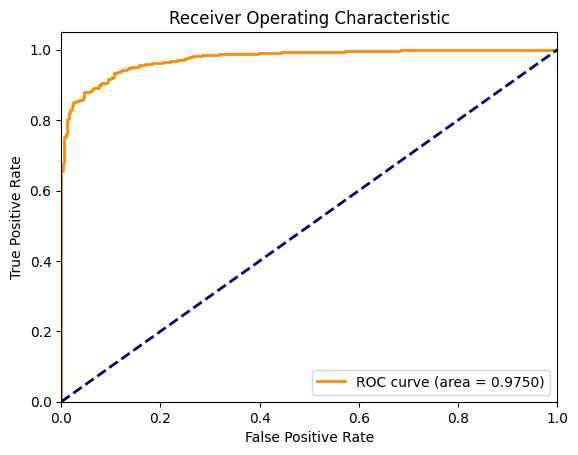

In [16]:
# Vẽ đường cong ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

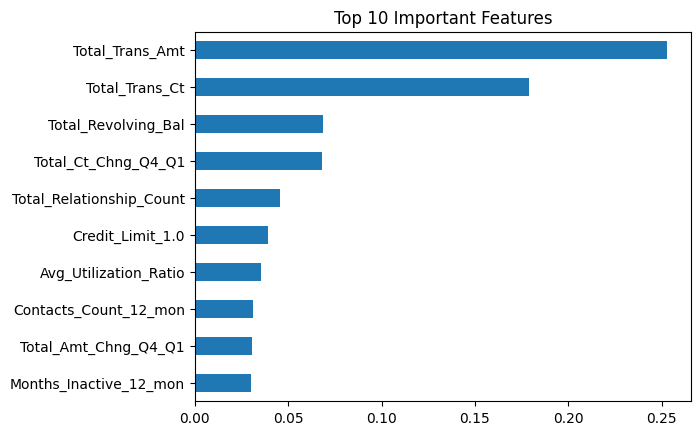

In [17]:
feat_importances = pd.Series(xgb_rd.feature_importances_, index=X_train_resampled.columns)
feat_importances.nlargest(10).sort_values().plot(kind='barh')
plt.title("Top 10 Important Features")
plt.show()